In [1]:
import warnings
import ast
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

warnings.filterwarnings("ignore")

In [2]:
PROJECT_NAME = "cassandra"
EXP_ID = "apch"
MODEL_HISTORY = 15
TOTAL_WINDOWS = 30
ALPHA = 0.05

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# load baseline evaluation results
base_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_base_eval.csv")
base_eval_df["model"] = "base"
base_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,0,1,0.676056,0.631579,0.653061,0.780083,0.717239,0.673126,0.814516,base
1,cassandra,0,2,0.577778,0.742857,0.650000,0.784725,0.725062,0.663368,0.707692,base
2,cassandra,0,3,0.451613,0.711864,0.552632,0.726890,0.674078,0.512411,0.638298,base
3,cassandra,0,4,0.713043,0.788462,0.748858,0.755759,0.719325,0.738969,0.656250,base
4,cassandra,0,5,0.521127,0.587302,0.552239,0.728710,0.664491,0.571430,0.751825,base


In [4]:
# load ecoselekt evaluation results
selekt_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selekt_eval.csv")
selekt_eval_df["model"] = "ecoselekt"
selekt_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,15,16,0.539683,0.557377,0.548387,0.809411,0.664146,0.685348,0.791367,ecoselekt
1,cassandra,15,17,0.730769,0.695122,0.712500,0.819192,0.755919,0.723686,0.822034,ecoselekt
2,cassandra,15,18,0.588235,0.645161,0.615385,0.801835,0.717119,0.676358,0.797101,ecoselekt
3,cassandra,15,19,0.528571,0.649123,0.582677,0.796651,0.706629,0.578697,0.769231,ecoselekt
4,cassandra,15,20,0.741176,0.707865,0.724138,0.798917,0.753371,0.728175,0.801802,ecoselekt


In [5]:
# load best select evaluation results
best_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_eval.csv")
best_eval_df["model"] = "best"
best_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,cassandra,15,16,0.738462,0.786885,0.761905,0.910839,0.831052,0.838543,0.877698,best
1,cassandra,15,17,0.802469,0.792683,0.797546,0.917166,0.827768,0.890199,0.864407,best
2,cassandra,15,18,0.700000,0.790323,0.742424,0.916199,0.818570,0.850618,0.847826,best
3,cassandra,15,19,0.687500,0.771930,0.727273,0.905840,0.814842,0.820150,0.860140,best
4,cassandra,15,20,0.811111,0.820225,0.815642,0.898320,0.833429,0.881026,0.846847,best


(240, 11)


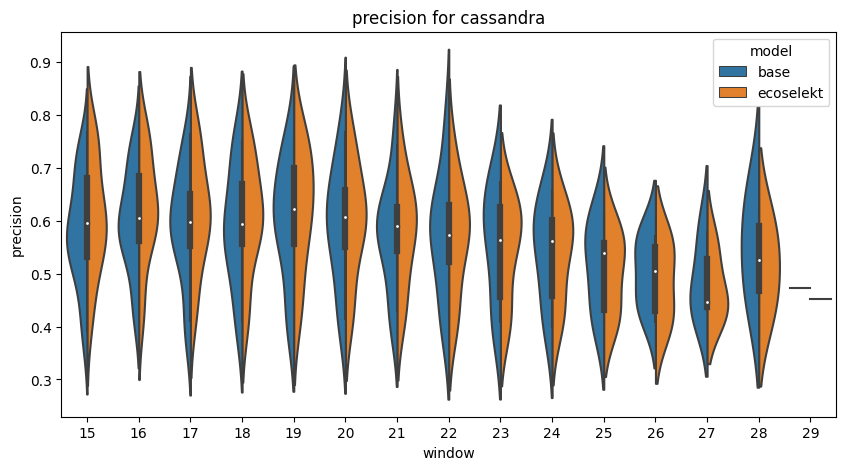

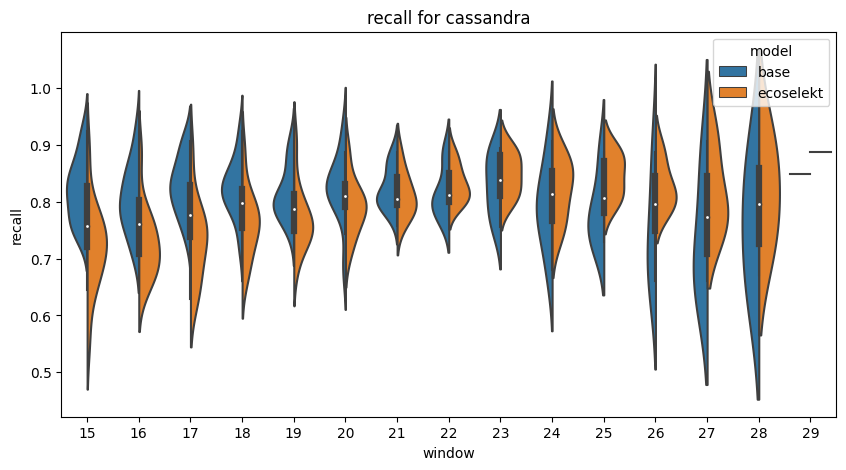

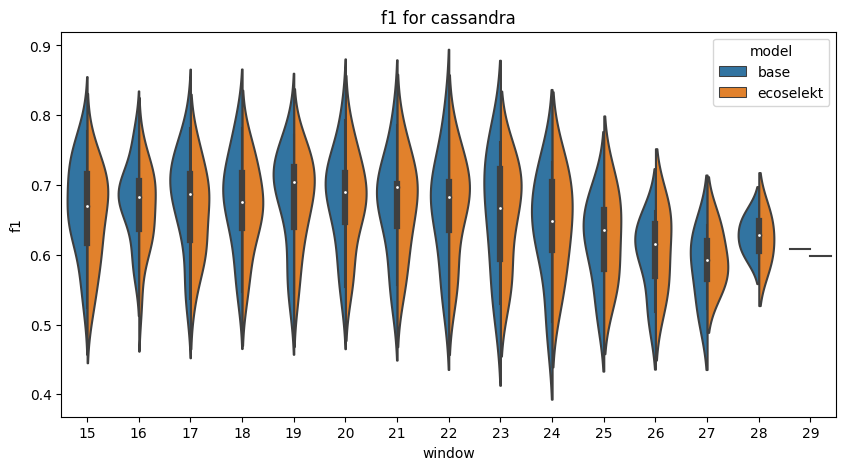

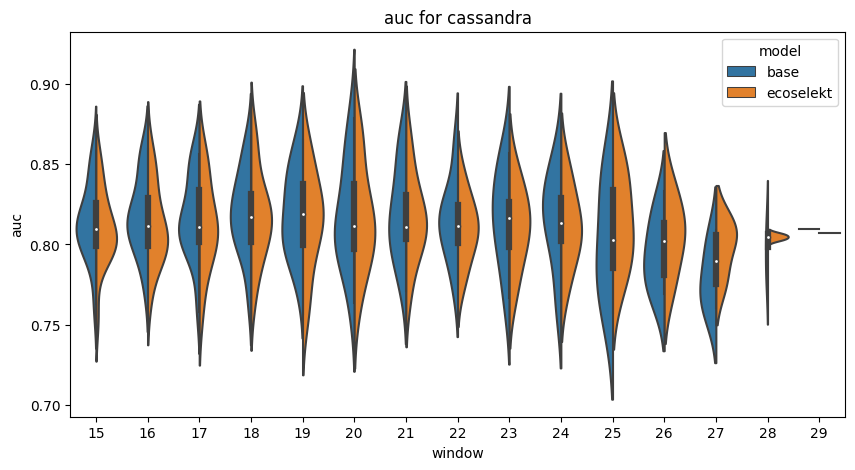

In [6]:
# concat base and ecoselekt evaluation dataframes keeping only common `window` and `test_split` then plot violin plots for each metric
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
print(eval_df.shape)

# plot violin plots for each metric
for metric in ["precision", "recall", "f1", "auc"]:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x="window", y=metric, data=eval_df, hue="model", split=True)
    plt.title(f"{metric} for {PROJECT_NAME}")
    plt.show()


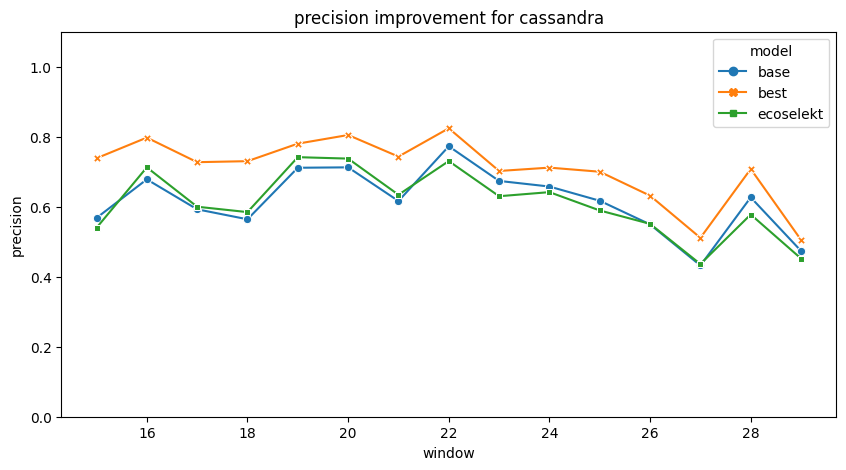

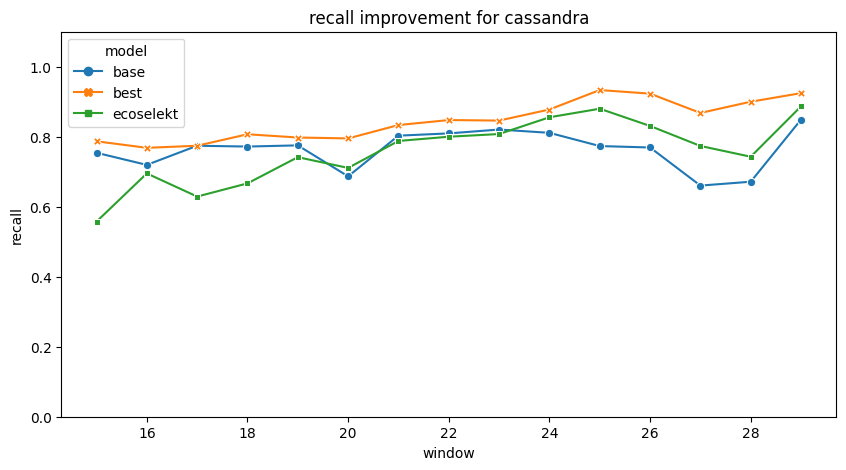

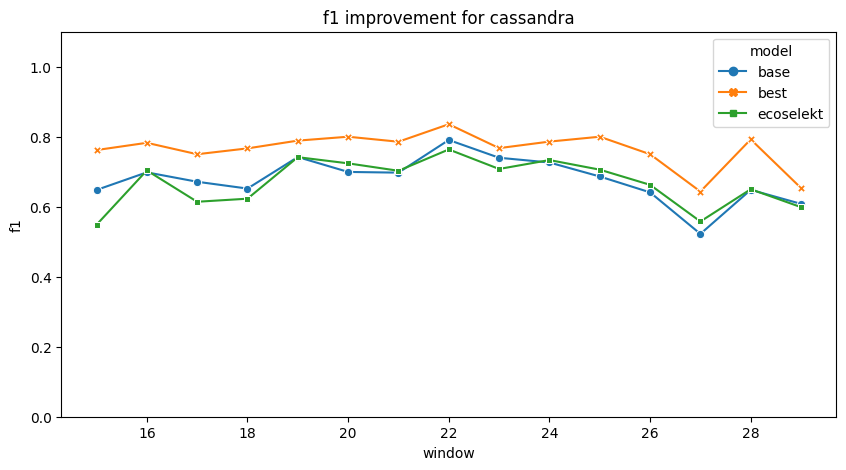

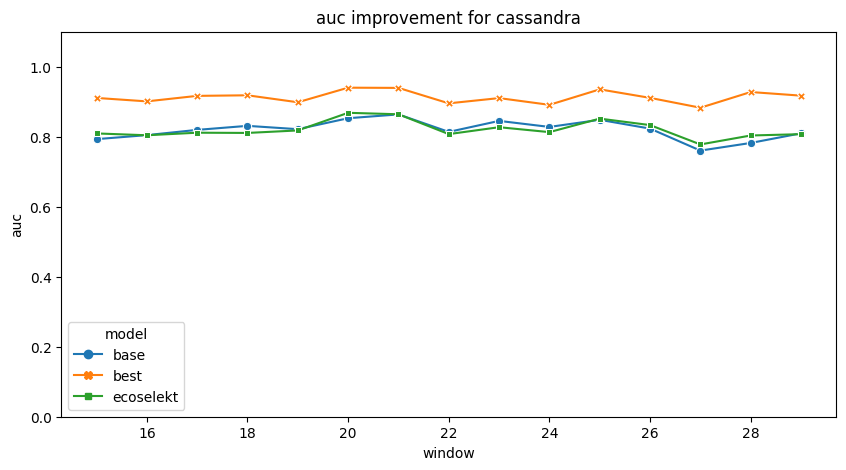

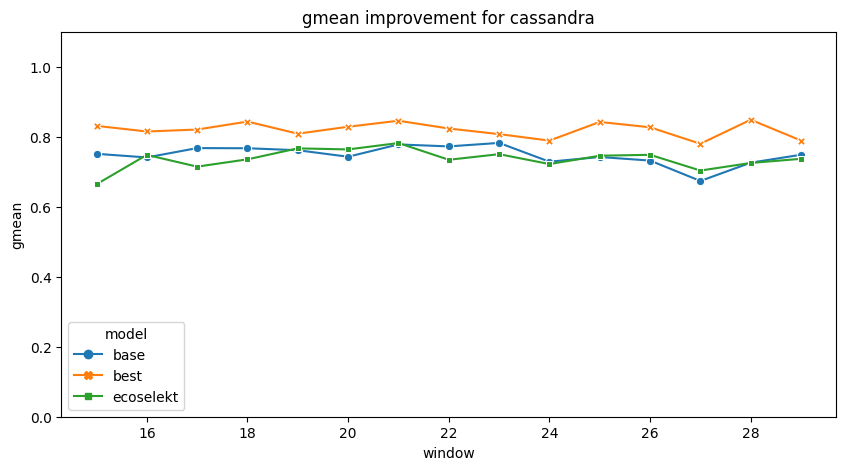

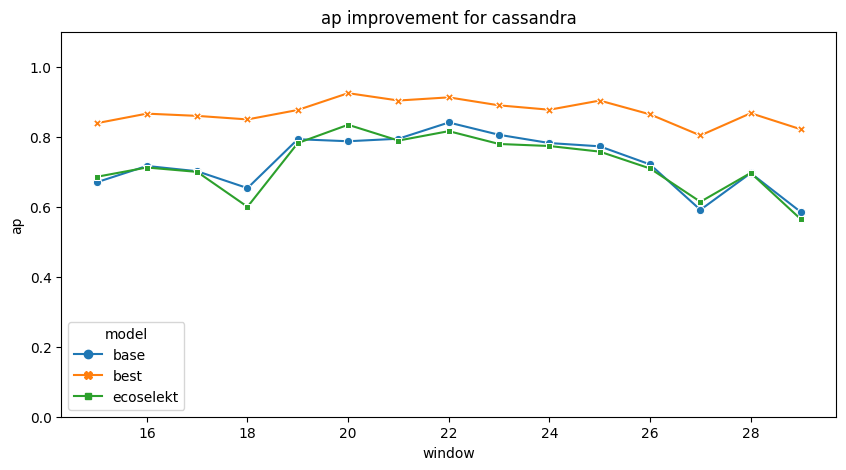

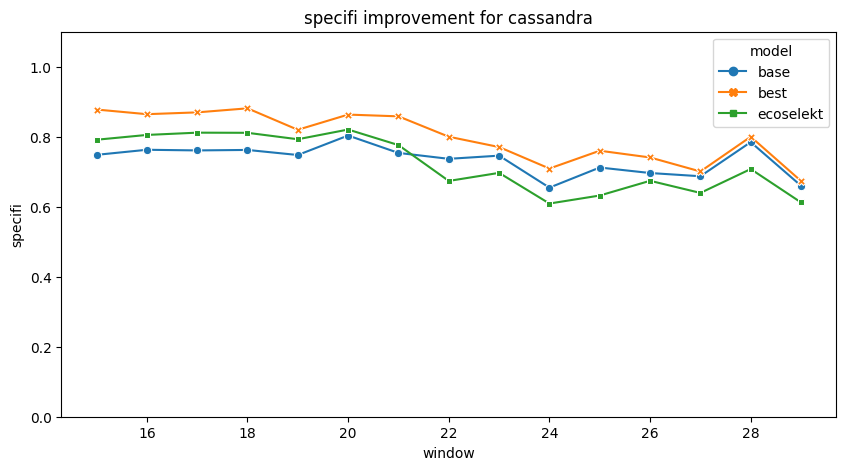

In [7]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

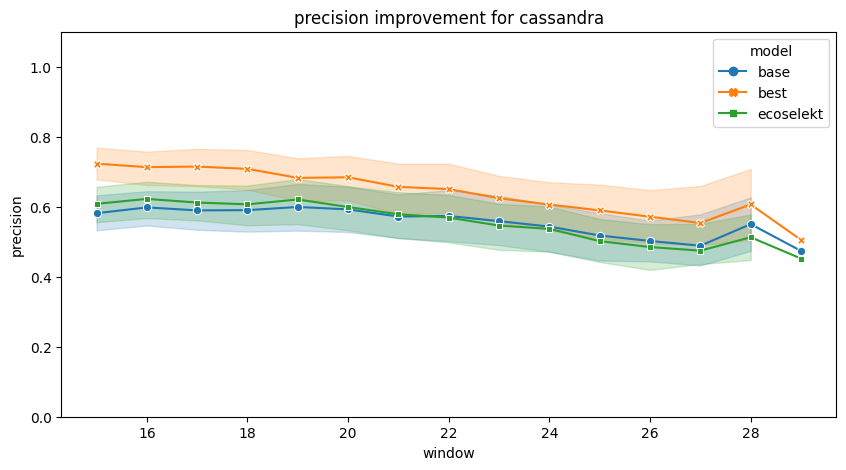

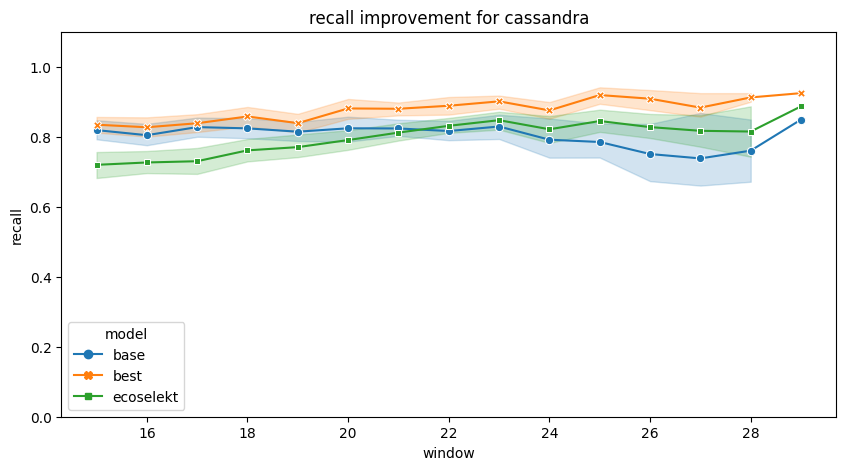

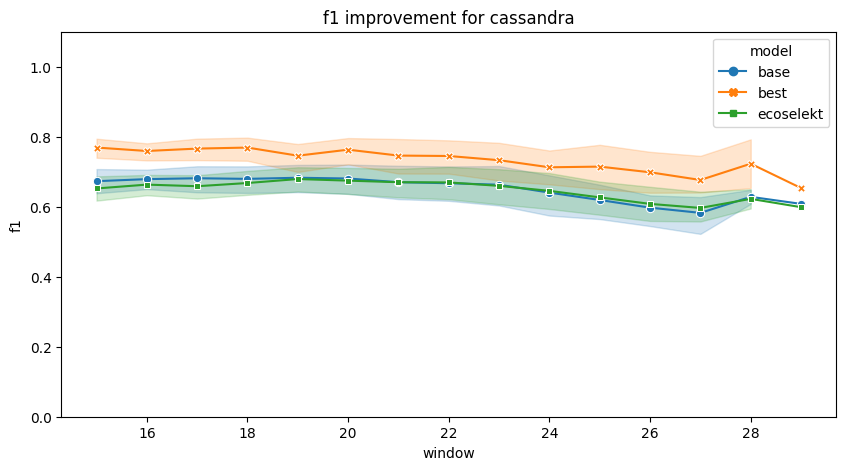

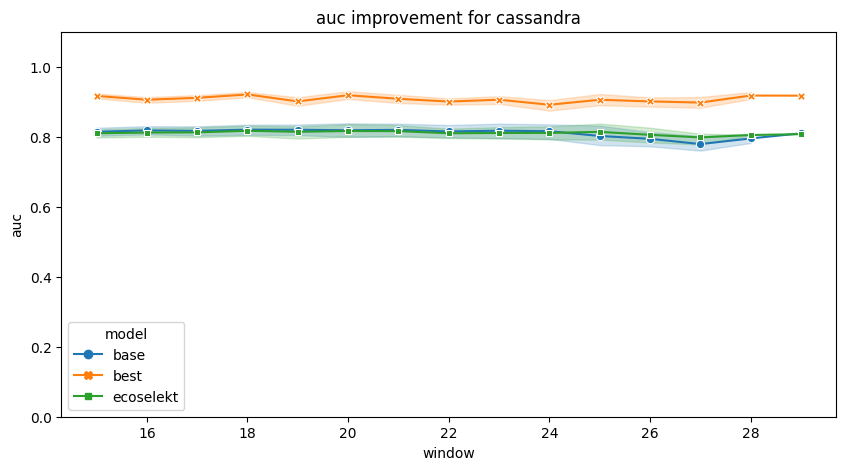

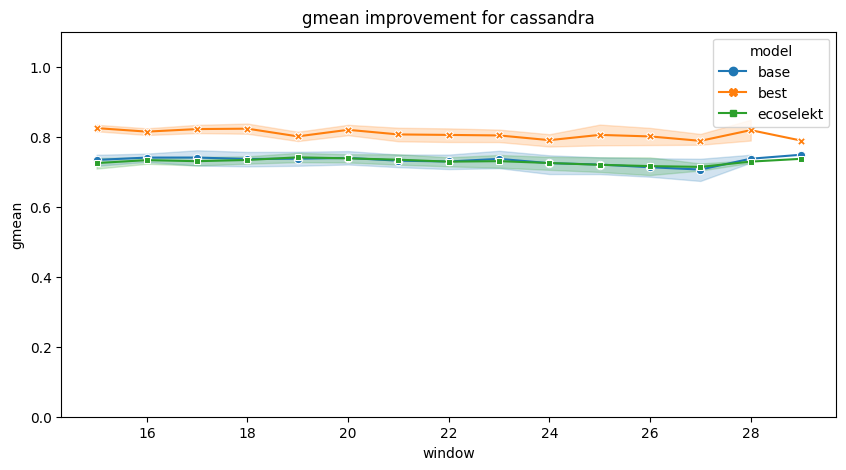

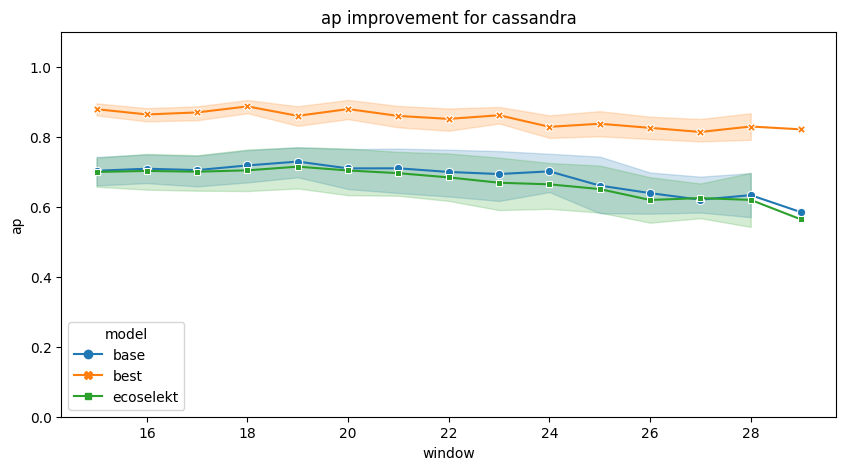

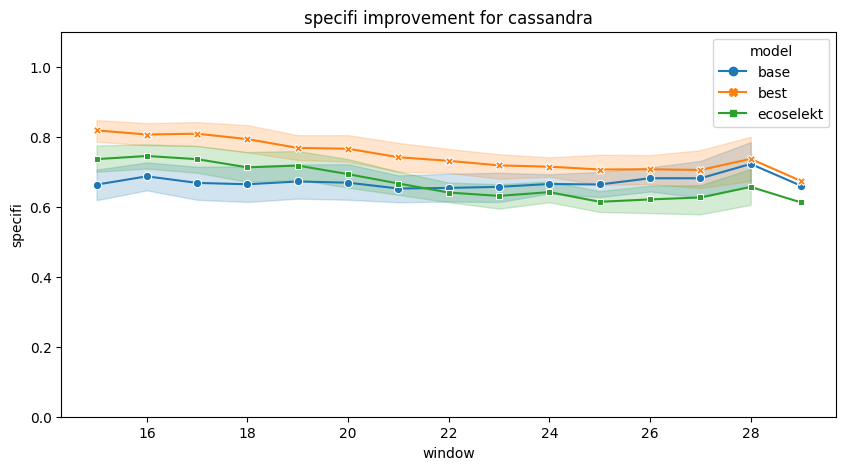

In [8]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

In [9]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["auc"], eval_df[eval_df["model"] == "base"]["auc"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.97796630859375
Wilcoxon test significance: False


In [10]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["recall"], eval_df[eval_df["model"] == "base"]["recall"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 0.890380859375
Wilcoxon test significance: False


In [11]:
bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_model_per_test_split.csv")
bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(bestmodel_df.shape)
bestmodel_df.head()

(24000, 4)


,commit_id,window,test_split,model_version
0,e674abe8eca6157b5c72c1dbdba2ecd122185274,15,16,2
1,6643dbdb1e1aef61c016b3f0c7d01c2c82ad91c0,15,16,2
2,f5d542c5a8c3dbdd80304220c9e2a7b030616daf,15,16,0
3,b34ed0db535068525e59f5c3ec20e2c29155467b,15,16,0
4,5f60fcc39c9ac8958bd2d8565404515f919d8124,15,16,0


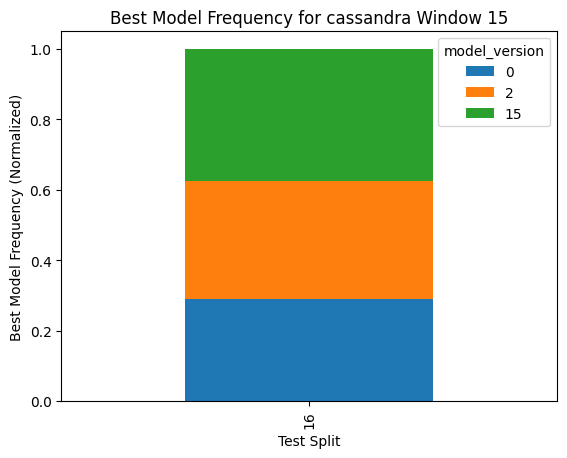

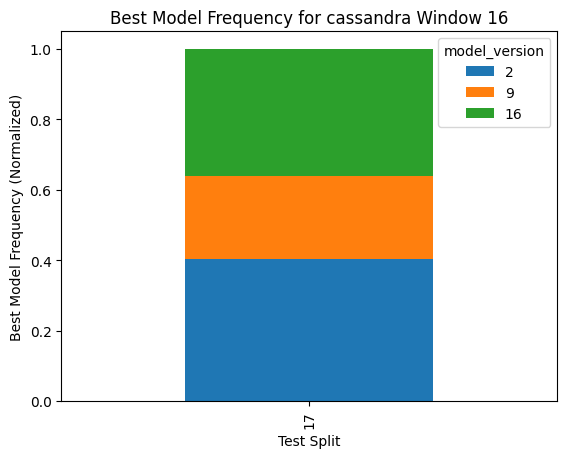

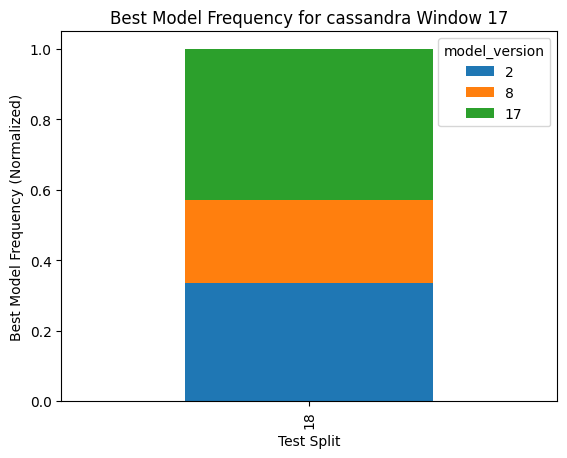

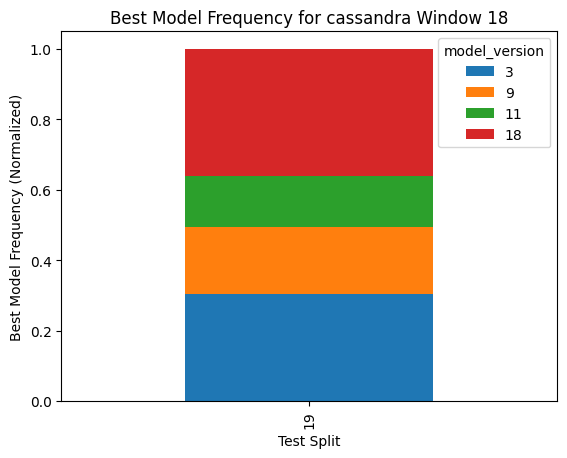

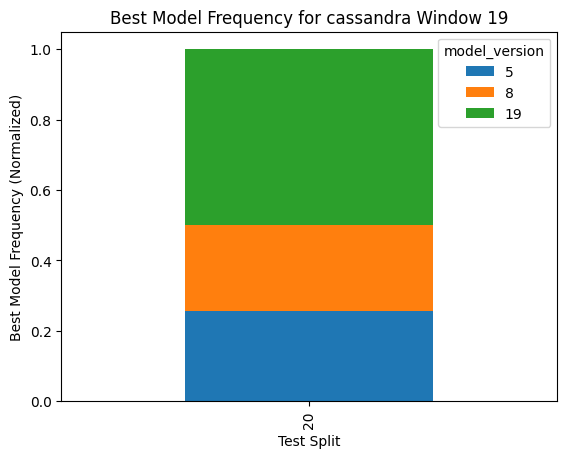

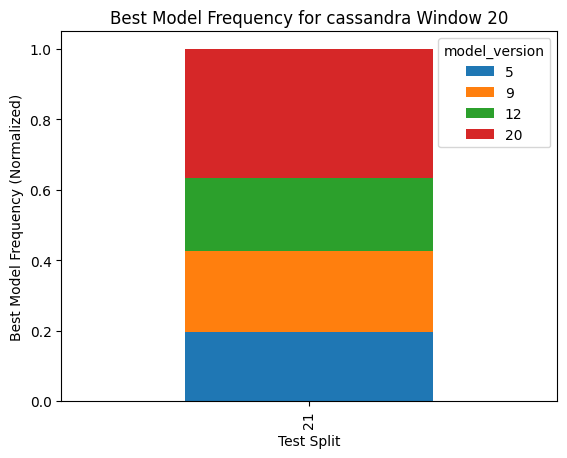

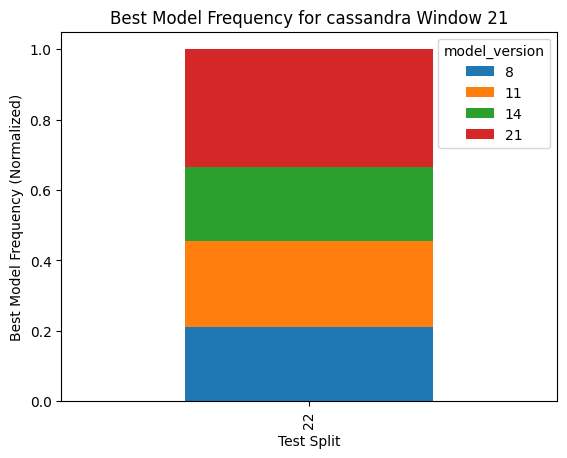

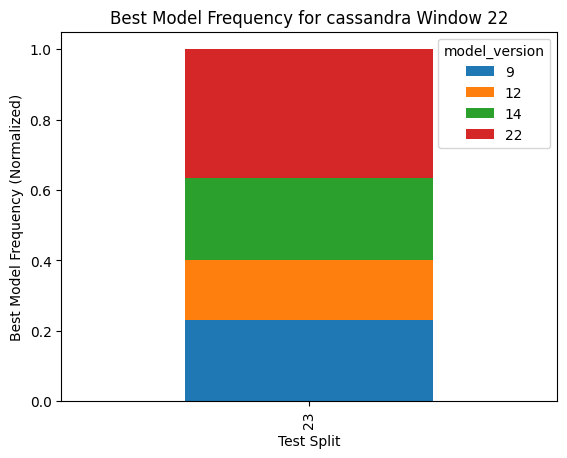

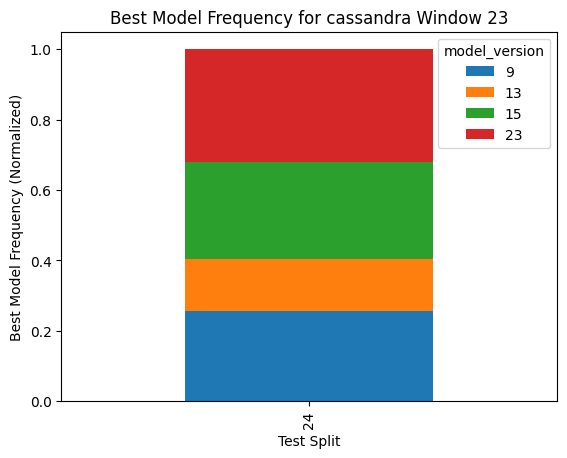

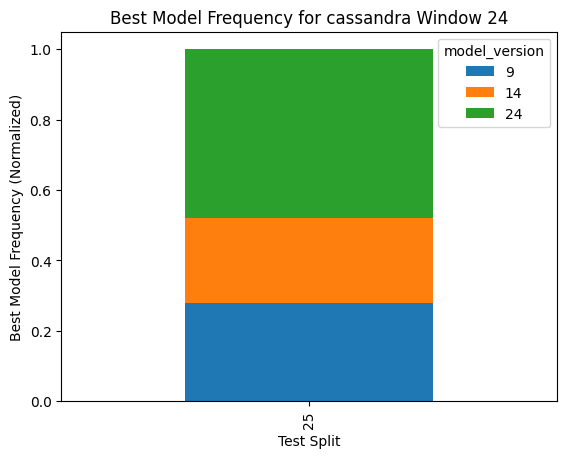

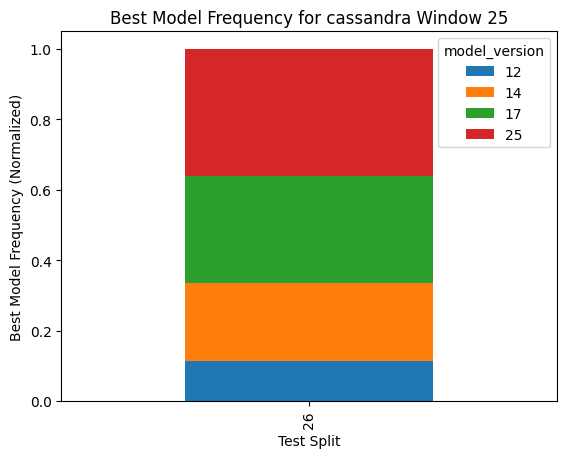

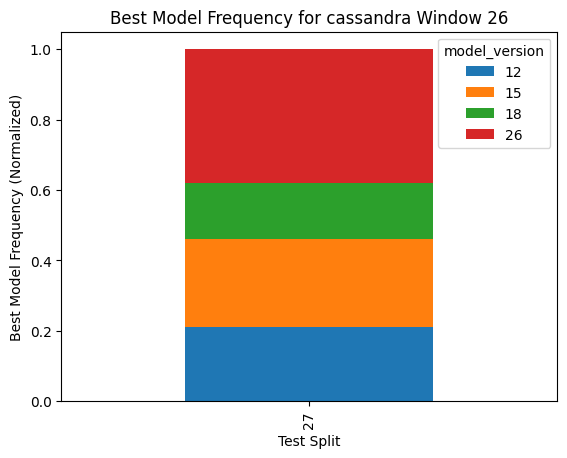

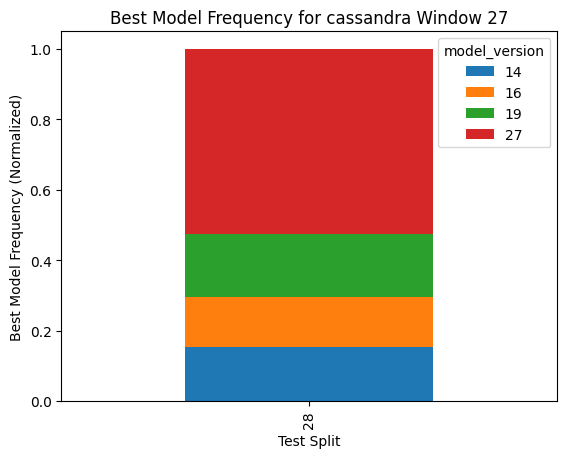

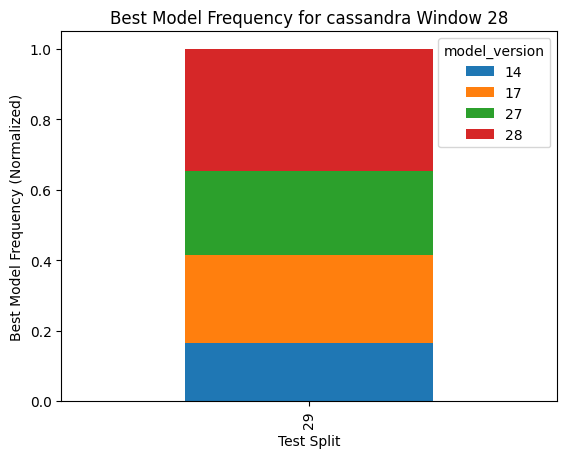

In [12]:
for i in range(MODEL_HISTORY,TOTAL_WINDOWS - 1):
    temp_bestmodel_df = bestmodel_df[bestmodel_df["window"] == i]
    temp_bestmodel_df = temp_bestmodel_df[temp_bestmodel_df["test_split"] == i + 1]

    # best model
    model_frequency_by_test_split = temp_bestmodel_df.groupby('test_split')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    p = normalized_model_frequency_by_test_split.plot(kind='bar', stacked=True)
    p.set_xlabel("Test Split")
    p.set_ylabel("Best Model Frequency (Normalized)")
    p.set_title(f"Best Model Frequency for {PROJECT_NAME} Window {i}")
    plt.show()